## PMF and virial coefficient calculations using VirtualTranslate - Analysis



PMF and virial coefficient calculation using VirtualTranslate

Let molecule A (index 0) be centered in the the middle of a spherical simulation cell and allowed to rotate only. Place another molecule, B (index 1), in on the positive $z$-axis and let it translate (dir=[0,0,1]) and rotate in such a way that it cannot cross to the negative $z$-axis. Add the following to the analysis:

yml
- virtualtranslate: {file: vt.dat, dL: 0.1, molecule: B, nstep: 10, dir: [0,0,1]}
- reactioncoordinate: {file: R.dat, nstep: 10, type: molecule, property: com_z, index: 1}

In [2]:
#Import packages

from __future__ import division, unicode_literals, print_function
from IPython.display import display, Math
from IPython.display import display, HTML
from scipy.integrate import quad
from scipy.optimize import curve_fit
from scipy import stats 
from math import *
import matplotlib as mpl, matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import scipy.integrate as integrate
import scipy.special as special
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as mtick
import os.path, os, sys, json, filecmp, copy
import mdtraj as md
import numpy as np
import pandas as pd
import statistics as st
#import in_place
import json
import shutil
import csv 
display(HTML(data="""
<style>
    div#notebook-container    { width: 100%; }
    div#menubar-container     { width: 100%; }
    div#maintoolbar-container { width: 100%; }
</style>
"""))

plt.rcParams.update({'font.size':14,'legend.frameon':True,'figure.figsize':[12,8],'xtick.major.size':7,'ytick.major.size':7,'legend.labelspacing':1})

## Get average force as a function of z-position of molecule B

In [2]:
#Working directory
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd -q $workdir

%cd $workdir/
###################

to_kJmol =2.476

##################################################################################################################################################
proteins = {'TLL_wildtype': {'eps': [0.05*to_kJmol], 'heps':[0.402*to_kJmol, 0.404*to_kJmol, 0.406*to_kJmol], 'input':workdir+'/tll-close_open.pqr'}}#
##################################################################################################################################################


def getForces(R_file, vt_file, f_file, bins, skip):
    ''' It counts the number of rows available in R.dat'''
    rows = 0
    with open(R_file, 'r') as f:
        for line in f:
            rows += 1
        print('steps = ', rows)
        
    ''' get average force as a function of z-position of molecule B '''
    R = np.loadtxt(R_file, usecols=[1], skiprows=skip, max_rows=rows-1000)
    steps, dL, du = np.loadtxt(vt_file, unpack=True, skiprows=1+skip, usecols=(0,1,2), max_rows=rows-1000)
    means, edges, bins = stats.binned_statistic(R, np.exp(-du), 'mean', bins)
    
    '''Save force profile'''
    with open(f_file, 'w') as f:
        writer = csv.writer(f, delimiter='\t')
        writer.writerows(zip(edges[1:], (np.log(means) / dL[0])))
    return #edges[1:], (np.log(means) / dL[0])


###############################################################################################################

for name, prop in proteins.items():
    for eps in prop['eps']:
        for heps in prop['heps']:
            for g in range(5):
                path = str(name)+'/'+str(eps)+'/'+str(heps)+'/'+str(g)+'/' 
                getForces(workdir+'/'+path+'R.dat', path+'vt.dat',  path+'Av_force_vs_r.dat', 100, 0)

                print(str(path), 'Done!')

/home/marpoli/Work/2_TLL/B2
steps =  10000000
TLL_wildtype/0.12380000000000001/0.995352/0/ Done!
steps =  10000000
TLL_wildtype/0.12380000000000001/0.995352/1/ Done!
steps =  10000000
TLL_wildtype/0.12380000000000001/0.995352/2/ Done!
steps =  10000000
TLL_wildtype/0.12380000000000001/0.995352/3/ Done!
steps =  10000000
TLL_wildtype/0.12380000000000001/0.995352/4/ Done!
steps =  10000000
TLL_wildtype/0.12380000000000001/1.000304/0/ Done!
steps =  10000000
TLL_wildtype/0.12380000000000001/1.000304/1/ Done!
steps =  10000000
TLL_wildtype/0.12380000000000001/1.000304/2/ Done!
steps =  10000000
TLL_wildtype/0.12380000000000001/1.000304/3/ Done!
steps =  10000000
TLL_wildtype/0.12380000000000001/1.000304/4/ Done!
steps =  10000000
TLL_wildtype/0.12380000000000001/1.0052560000000001/0/ Done!
steps =  10000000
TLL_wildtype/0.12380000000000001/1.0052560000000001/1/ Done!
steps =  10000000
TLL_wildtype/0.12380000000000001/1.0052560000000001/2/ Done!
steps =  10000000
TLL_wildtype/0.123800000000

## Single PMFs

/home/marpoli/Work/2_TLL/github/twobody_swap_move


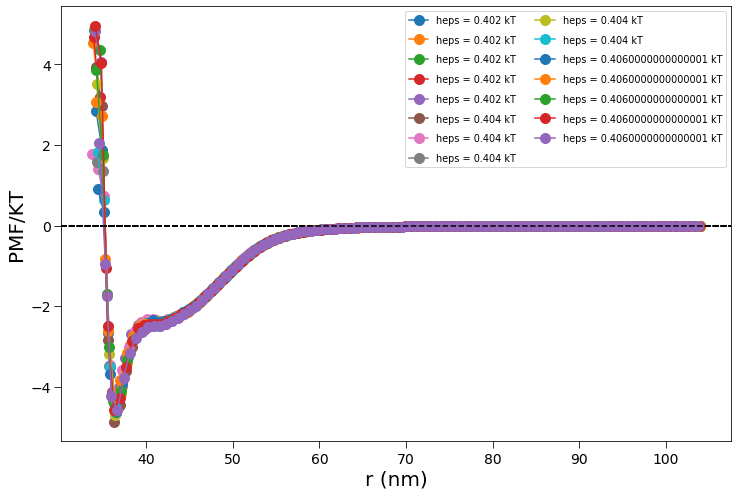

In [3]:
#Working directory
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd -q $workdir

%cd $workdir/
###################

to_kJmol =2.476

##################################################################################################################################################
proteins = {'TLL_wildtype': {'eps': [0.05*to_kJmol], 'heps':[0.402*to_kJmol, 0.404*to_kJmol, 0.406*to_kJmol], 'input':workdir+'/tll-close_open.pqr'}}#
##################################################################################################################################################


#markers  = ['b.-', 'rv-', 'gx-', 'b.-', 'rv-', 'gx-', 'b.-', 'rv-', 'gx-', 'b.-', 'rv-', 'gx-']
B2 = np.empty(0)
SIM_data = np.empty(0)

for name, prop in proteins.items():
    for eps in prop['eps']:
        for heps in prop['heps']:
            for g in range(5):
                path = str(name)+'/'+str(eps)+'/'+str(heps)+'/'+str(g)+'/' 
                # load force profile
                R, force = np.loadtxt(workdir+'/'+path+'Av_force_vs_r.dat', unpack=True, usecols=(0,1))
                R=R[:]
                force=force[:]
                R[np.isnan(R)]=0
                force[np.isnan(force)]=0

                # get PMF and normalize
                pmf = -np.cumsum(force)*np.diff(R)[:].mean()
                pmf = pmf - pmf[-1]

                # plot pmf
                plt.plot(R, pmf,'o-',  label='heps = '+str(heps/to_kJmol)+' kT', markersize=10)
                plt.axhline(y=0, color='k', linestyle='--')
                plt.xlabel('r (nm)', fontsize=20)
                plt.ylabel('PMF/KT', fontsize=20)
                plt.legend(ncol=2, fontsize='x-small')


plt.show()

##  $B_{2}$ from each replica

In [4]:
#Working directory
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd -q $workdir

%cd $workdir/
###################

to_kJmol =2.476

################################################################################################################################################################################################
proteins = {'TLL_wildtype': {'eps': [0.05*to_kJmol], 'heps':[0.38*to_kJmol,0.4*to_kJmol,0.402*to_kJmol, 0.404*to_kJmol, 0.406*to_kJmol, 0.42*to_kJmol], 'input':workdir+'/tll-close_open.pqr'}}#
################################################################################################################################################################################################


B2_all = np.empty(0)
SIM_data = np.empty(0)

for name, prop in proteins.items():
    for eps in prop['eps']:
        for heps in prop['heps']:
            for g in range(5):
                path = str(name)+'/'+str(eps)+'/'+str(heps)+'/'+str(g)+'/' 
                #Mw = prop['Mw']

                # load average force
                R, force = np.loadtxt(workdir+'/'+path+'Av_force_vs_r.dat', unpack=True, usecols=(0,1))
                R=R[:]
                force=force[:]
                R[np.isnan(R)]=0
                force[np.isnan(force)]=0
                sigma = 27.8*2#R.min()
                #print('sigma = ',sigma, 'Å')

                # integrate simulated force to get PMF and normalize
                pmf = -np.cumsum(force)*np.diff(R)[:].mean()
                #pmf = -np.cumsum(force)*np.diff(R).mean()
                #print(-np.cumsum(force)[0:2])
                pmf = pmf - pmf[-1]

                # integrate to get second virial
                B2hs = (2*np.pi*sigma**3)/3
                B2_vt = -2 * np.pi * np.trapz( np.expm1(-pmf)*R**2, R)
                B2 = (B2_vt+B2hs)/B2hs
                #######################################################
                #print("B2hs =", B2hs,'Å^{3}')
                #print("B2vt= ", B2_vt,'Åˆ3')
                #print("B2hs =", B2hs)#*6.022e23*1e-24/Mw/Mw,'mL mol/g**2')
                #print("B2vt= ", B2_vt)#*6.022e23*1e-24/Mw/Mw,'mL mol/g**2')
                print('eps = '+str(eps),'hesp = '+str(heps),' -- B2/B2HF', B2)#*6.022e23*1e-24/Mw/Mw,'mL mol/g**2')
                #print("B2* = B2/B2hs =", (B2hs + B2_vt)/B2hs  )
                #######################################################
                #B2_tot = np.append(B2_tot, B2*6.022e23/1e27 )
                B2_all = np.append(B2_all, B2)#*6.022e23*1e-24/Mw/Mw )
                #print('heps = '+str(heps/to_kJmol), 'B2 = '+ str(B2_norm))
                #print('')
                #print('')

/home/marpoli/Work/2_TLL/github/twobody_swap_move
eps = 0.12380000000000001 hesp = 0.94088  -- B2/B2HF -2.92655936196809
eps = 0.12380000000000001 hesp = 0.94088  -- B2/B2HF -2.517666450794397
eps = 0.12380000000000001 hesp = 0.94088  -- B2/B2HF -2.884989588295826
eps = 0.12380000000000001 hesp = 0.94088  -- B2/B2HF -3.1529448031124816
eps = 0.12380000000000001 hesp = 0.94088  -- B2/B2HF -2.6010822925491093
eps = 0.12380000000000001 hesp = 0.9904000000000001  -- B2/B2HF -4.894471429289133
eps = 0.12380000000000001 hesp = 0.9904000000000001  -- B2/B2HF -4.662159537476005
eps = 0.12380000000000001 hesp = 0.9904000000000001  -- B2/B2HF -5.472408367408131
eps = 0.12380000000000001 hesp = 0.9904000000000001  -- B2/B2HF -4.909739475613124
eps = 0.12380000000000001 hesp = 0.9904000000000001  -- B2/B2HF -4.452026199095734
eps = 0.12380000000000001 hesp = 0.995352  -- B2/B2HF -5.057809387424651
eps = 0.12380000000000001 hesp = 0.995352  -- B2/B2HF -5.597951196073306
eps = 0.12380000000000001 he

### B2 replica plots

/home/marpoli/Work/2_TLL/github/twobody_swap_move


Text(0, 0.5, '$B_{2}/B_{2HF}$')

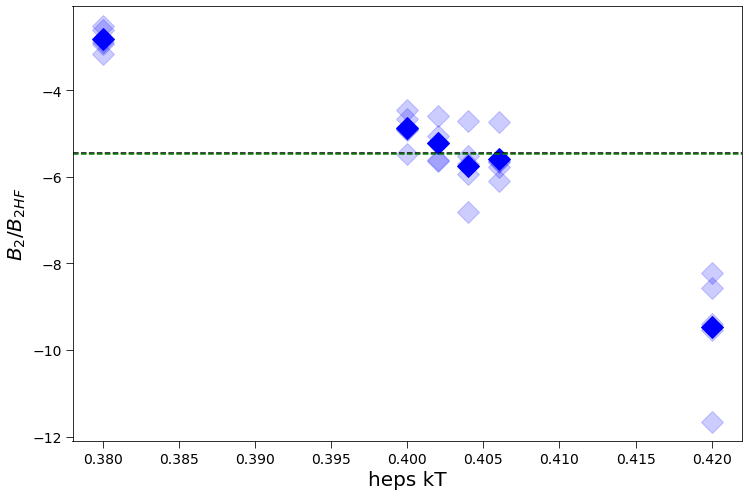

In [5]:
# B2 mol Ml /g2

try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd -q $workdir

%cd $workdir/
###############################

heps_0 = [0.38]*5
heps_1 = [0.40]*5
heps_2 = [0.402]*5
heps_3 = [0.404]*5
heps_4 = [0.406]*5
heps_5 = [0.42]*5


plt.plot(heps_0, B2_all[:5], 'Db', markersize=15, alpha=0.2, label='heps = '+str(heps_0)+' kT' )
plt.plot(heps_0[0], np.mean(B2_all[:5]), 'Db', markersize=15, alpha=1, label='heps = '+str(heps_0)+' kT' )

plt.plot(heps_1, B2_all[5:10], 'Db', markersize=15, alpha=0.2, label='heps = '+str(heps_1)+' kT' )
plt.plot(heps_1[0], np.mean(B2_all[5:10]), 'Db', markersize=15, alpha=1, label='heps = '+str(heps_1)+' kT' )

plt.plot(heps_2, B2_all[10:15], 'Db', markersize=15, alpha=0.2, label='heps = '+str(heps_2)+' kT' )
plt.plot(heps_2[0], np.mean(B2_all[10:15]), 'Db', markersize=15, alpha=1, label='heps = '+str(heps_2)+' kT' )

plt.plot(heps_3, B2_all[15:20], 'Db', markersize=15, alpha=0.2, label='heps = '+str(heps_0)+' kT' )
plt.plot(heps_3[0], np.mean(B2_all[15:20]), 'Db', markersize=15, alpha=1, label='heps = '+str(heps_0)+' kT' )

plt.plot(heps_4, B2_all[20:25], 'Db', markersize=15, alpha=0.2, label='heps = '+str(heps_1)+' kT' )
plt.plot(heps_4[0], np.mean(B2_all[20:25]), 'Db', markersize=15, alpha=1, label='heps = '+str(heps_1)+' kT' )

plt.plot(heps_5, B2_all[25:30], 'Db', markersize=15, alpha=0.2, label='heps = '+str(heps_2)+' kT' )
plt.plot(heps_5[0], np.mean(B2_all[25:30]), 'Db', markersize=15, alpha=1, label='heps = '+str(heps_2)+' kT' )


####################################################################################################
#B2_PPI03_exp = [4.36e-4, 0.553e-4, 0.255e-4, 0.121e-4]
#B2_PPI13_exp = [2.39e-4, -1.51e-4, -0.762e-4, -0.856e-4]
#plt.plot(salt, B2_PPI03_exp, 'xb', label='PPI03 exp', markersize=20, alpha=1 )
#plt.plot(salt, B2_PPI13_exp, 'xr', label='PPI13 exp',  markersize=20, alpha=1)
            
plt.axhline(y=-5.44, color='k', linestyle='--')
plt.axhline(y=-5.477, color='g', linestyle='--')
plt.xlabel('heps kT', fontsize=20)
plt.ylabel("$B_{2}/B_{2HF}$", fontsize=20)
#plt.legend()
#print(np.mean(B2_all[:2]))

##  PMFs interpolation and corresponding $B_{2}$

/home/marpoli/Work/2_TLL/github/twobody_swap_move


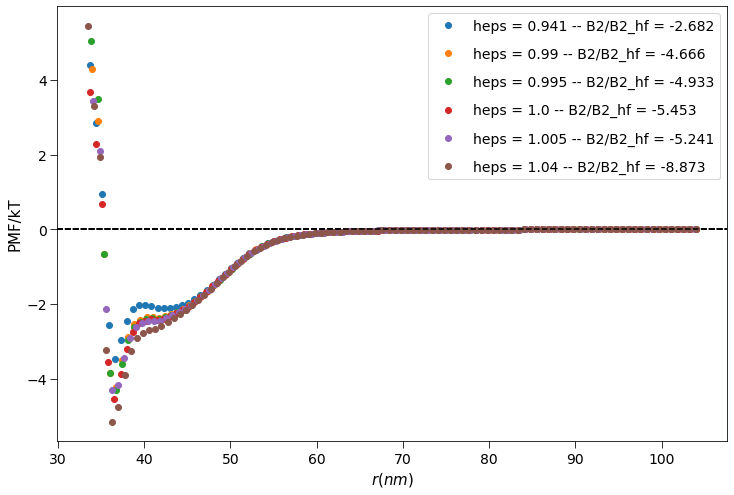

In [6]:
#Working directory#
try:               
    workdir        
except NameError:   
    workdir=%pwd   
else:              
    %cd -q $workdir
                   
%cd $workdir/      
####################

#########################################################
def f_force(filename, cols=(0,1)):
    R, F = np.loadtxt(filename,usecols=cols,unpack=True)
    R[np.isnan(R)]=0
    F[np.isnan(F)]=0
    return R,F
#########################################################

##################################################################################################################################################
proteins = {'TLL_wildtype': {'eps': [0.05*to_kJmol], 'heps':[0.38*to_kJmol,0.4*to_kJmol,0.402*to_kJmol, 0.404*to_kJmol, 0.406*to_kJmol, 0.42*to_kJmol], 'input':workdir+'/tll-close_open.pqr'}}#
##################################################################################################################################################

#################################################### Append force ######################################################
replicas = r = 5
force = []



#parse each line from the datafile into a tuple of the form (xvals,yvals) store that tuple in a list.
for name, prop in proteins.items():
    for eps in prop['eps']:
        for heps in prop['heps']:
            for g in range(replicas):
                path = str(name)+'/'+str(eps)+'/'+str(heps)+'/'+str(g)+'/Av_force_vs_r.dat'                     
                #filename2 = 'Av_force_vs_r.dat'
                force.append(f_force(path))
########################################################################################################################
##################################################### Interpolation ####################################################

n_points = 100 # point for interpolation
B2s = np.empty(0)
a = 0
b = r

for f in range(len(prop['heps'])):
    ##################### Interpolate Force and average pmf ########################
    xmin_force = min(line[0].min() for line in force[a:b])
    xmax_force = max(line[0].max() for line in force[a:b])
    x_points_force = np.linspace(xmin_force, xmax_force, n_points)
    interpolated_force = [np.interp(x_points_force, d[0], d[1]) for d in force[a:b]]
    average_force = [np.average(x) for x in zip(*interpolated_force)]

    pmf = -np.cumsum(average_force)*np.diff(x_points_force)[:].mean()
    pmf = (pmf - pmf[-1]) 
    ################################# Calculate B2 #################################
    sigma = 27.8*2
    B2_hs = (2*np.pi*sigma**3)/3
    B2_vt = -2 * np.pi * np.trapz(np.expm1(-pmf)*x_points_force**2, x_points_force)
    B2 = (B2_hs + B2_vt)/B2_hs
    B2s = np.append(B2s, B2)
    ################################## Plot ########################################
    plt.plot(x_points_force, pmf,'o', label='heps = '+str(round(prop['heps'][f],3))+' -- B2/B2_hf = '+str(round(B2, 3)))  
    plt.axhline(y=0, color='k', linestyle='--')
    plt.xlabel('$r (nm)$', fontsize=15)
    plt.ylabel('PMF/kT', fontsize=15)

    #pmf to compare 
    #x, y = np.loadtxt('/home/marpoli/Work/2_TLL/info_Coralie/'+'tll-closed-ehh0.61-e0.05-pmf.dat', unpack=True, usecols=(0,1))
    #plt.plot(x,y, 'Dr--',  label='Coralie - B2/B2_hf = -5.477', markersize=5, alpha=0.2)
    plt.legend()
    a = a + r
    b = b + r

## B2 after interpolation plots

/home/marpoli/Work/2_TLL/github/twobody_swap_move


Text(0, 0.5, '$B_{2}/B_{2HF}$')

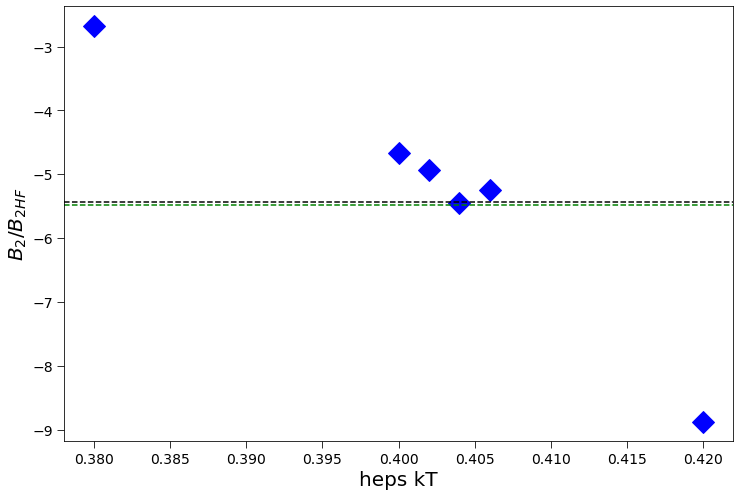

In [7]:
# B2 mol Ml /g2

try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd -q $workdir

%cd $workdir/
###############################

heps_0 = [0.38]
heps_1 = [0.40]
heps_2 = [0.402]
heps_3 = [0.404]
heps_4 = [0.406]
heps_5 = [0.42]


plt.plot(heps_0, B2s[0], 'Db', markersize=15, alpha=1, label='heps = '+str(heps_0)+' kT' )
plt.plot(heps_1, B2s[1], 'Db', markersize=15, alpha=1, label='heps = '+str(heps_1)+' kT' )
plt.plot(heps_2, B2s[2], 'Db', markersize=15, alpha=1, label='heps = '+str(heps_2)+' kT' )
plt.plot(heps_3, B2s[3], 'Db', markersize=15, alpha=1, label='heps = '+str(heps_0)+' kT' )
plt.plot(heps_4, B2s[4], 'Db', markersize=15, alpha=1, label='heps = '+str(heps_1)+' kT' )
plt.plot(heps_5, B2s[5], 'Db', markersize=15, alpha=1, label='heps = '+str(heps_2)+' kT' )
####################################################################################################
        
plt.axhline(y=-5.44, color='k', linestyle='--')
plt.axhline(y=-5.477, color='g', linestyle='--')
plt.xlabel('heps kT', fontsize=20)
plt.ylabel("$B_{2}/B_{2HF}$", fontsize=20)
#plt.legend()
#print(np.mean(B2_all[:2]))